# PART 3: MODELLING

In [14]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statistics import mean, median, quantiles, variance
import datetime
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression

import pickle
import unicodedata
import shap

In [43]:
# remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

## BLOCK 1: XGB MODEL

Now we are going to predict given a date and the sector (domestic, industrial or comercial) if the consumption will be higher or lower than the consumption during covid.

In [15]:
#OPEN DATA
data_barcelona = pd.read_csv("C:/Users/mirei/OneDrive/Escritorio/TFG/datasets/clean_datasets/block1/data_water_global.csv", sep=",")

In [16]:
data_barcelona

FECHA  USO  CONSUMO  ID_CONTADOR   LOCATION  YEAR  MONTH  \
0        2019-02-14    0        2          838  BARCELONA  2019      2   
1        2019-02-14    0       79         1207  BARCELONA  2019      2   
2        2019-02-17    0       12         1135  BARCELONA  2019      2   
3        2019-02-03    0      113         1328  BARCELONA  2019      2   
4        2019-02-11    0       22         1258  BARCELONA  2019      2   
...             ...  ...      ...          ...        ...   ...    ...   
3139398  2021-12-12    1      429        18780  BARCELONA  2021     12   
3139399  2021-12-13    1      311         7935  BARCELONA  2021     12   
3139400  2021-12-13    1      332        14312  BARCELONA  2021     12   
3139401  2021-12-14    1      821        14312  BARCELONA  2021     12   
3139402  2021-12-14    1     1802        10862  BARCELONA  2021     12   

         COVID_STATE  CONSUMO_COVID MONTH_LONG  TEMPERATURE  
0                  1              0     Febrer         11.9  
1                  1              0     Febrer         11.9  
2                  1              0     Febrer         11.9  
3                  1              0     Febrer         11.9  
4                  1              0     Febrer         11.9  
...              ...            ...        ...          ...  
3139398            0              0   Desembre         10.9  
3139399            0              0   Desembre         10.9  
3139400            0              0   Desembre         10.9  
3139401            0              0   Desembre         10.9  
3139402            0              0   Desembre         10.9  

[3139403 rows x 11 columns]

In [17]:
# Split
data_barcelona = data_barcelona.drop(['CONSUMO', 'FECHA', 'LOCATION', 'COVID_STATE', 'ID_CONTADOR', 'MONTH_LONG'], axis=1)
y= data_barcelona.loc[:, "CONSUMO_COVID"]
x= data_barcelona.loc[:, data_barcelona.drop('CONSUMO_COVID',axis=1).columns]
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8)

In [18]:
#XGBoost classifier
model_xgb = XGBClassifier().fit(x_train, y_train)
predict_xgb = model_xgb.predict(x_test)

In [19]:
#Confusion matrix
f1_score = f1_score(y_test, predict_xgb)
print('f1_score: ', f1_score)
confusion_matrix(y_test, predict_xgb)

f1_score:  0.0


array([[558788,      0],
       [ 69093,      0]], dtype=int64)

In [20]:
#Accuracy score
accuracy_score(y_test, predict_xgb)

0.8899584475402186

In [21]:
#Classification report
print(classification_report(y_test, predict_xgb))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.89      1.00      0.94    558788
           1       0.00      0.00      0.00     69093

    accuracy                           0.89    627881
   macro avg       0.44      0.50      0.47    627881
weighted avg       0.79      0.89      0.84    627881



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### INTERPRETATION: SHAP VALUES

In [22]:
#Create the explainer
explainer = shap.TreeExplainer(model_xgb)

#Calculate the shap_values for x_test
shap_values = explainer(x_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [23]:
shap_values

.values =
array([[-3.0515106 , -0.27516207, -0.00538478,  0.06307207],
       [-4.3001595 ,  0.06291491,  0.17482762, -0.4579644 ],
       [-4.5488424 , -0.1390798 , -0.19691172, -0.01868285],
       ...,
       [-3.0189266 , -0.12085263, -0.01605598,  0.03298092],
       [-4.328918  ,  0.16313452, -0.05114287,  0.25130746],
       [ 1.5501542 , -0.10206957,  0.19634184,  0.01988697]],
      dtype=float32)

.base_values =
array([-2.348371, -2.348371, -2.348371, ..., -2.348371, -2.348371,
       -2.348371], dtype=float32)

.data =
array([[2.000e+00, 2.020e+03, 7.000e+00, 2.500e+01],
       [1.000e+00, 2.021e+03, 1.000e+00, 7.700e+00],
       [1.000e+00, 2.020e+03, 3.000e+00, 1.190e+01],
       ...,
       [2.000e+00, 2.021e+03, 6.000e+00, 2.330e+01],
       [1.000e+00, 2.021e+03, 7.000e+00, 2.480e+01],
       [0.000e+00, 2.020e+03, 1.000e+00, 1.000e+01]])

Now we will take into account the first element of the dataset

In [24]:
print("Shap values for first element: \n", shap_values[0])

Shap values for first element: 
 .values =
array([-3.0515106 , -0.27516207, -0.00538478,  0.06307207], dtype=float32)

.base_values =
-2.348371

.data =
array([2.00e+00, 2.02e+03, 7.00e+00, 2.50e+01])


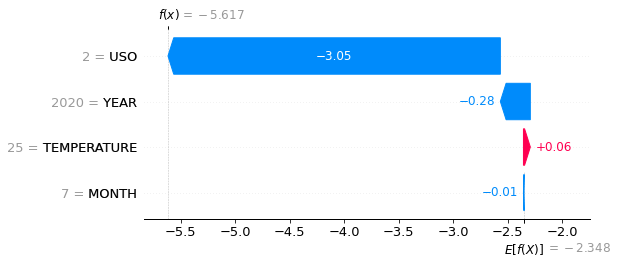

In [25]:
#waterfall
shap.plots.waterfall(shap_values[0])

In [26]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0], link = "logit")

In [27]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0])

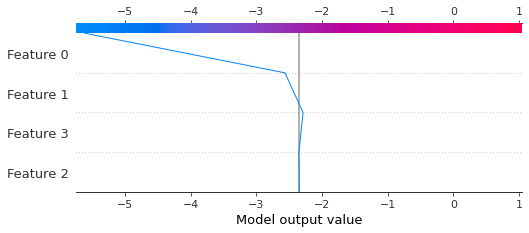

In [28]:
#decision_plot
shap.decision_plot(explainer.expected_value, shap_values.values[0])

#### Global Explanation

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


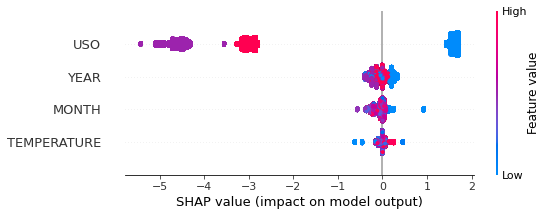

In [29]:
shap.summary_plot(shap_values, x_test)

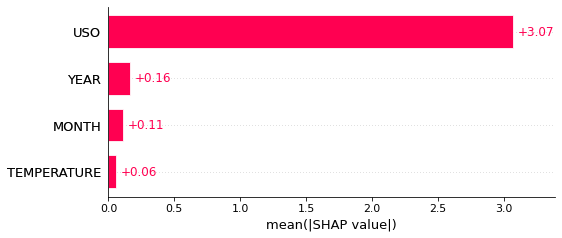

In [30]:
shap.plots.bar(shap_values)

## BLOCK 2: CLUSTERING KMEANS

In [31]:
# OPEN DATA
data_actividad_barcelona = pd.read_csv("C:/Users/mirei/OneDrive/Escritorio/TFG/datasets/clean_datasets/block2/data_activity_water.csv", sep=",")

In [44]:
# remove outliers
data_actividad_barcelona = remove_outlier(data_actividad_barcelona, 'CONSUMO')

In [45]:
data_actividad_barcelona

FECHA  CONSUMO EPIGRAF  \
0        2019-01-01       45   I6442   
1        2019-01-02      244   I6442   
2        2019-01-03      261   I6442   
3        2019-01-04      273   I6442   
4        2019-01-05      212   I6442   
...             ...      ...     ...   
1868867  2021-12-12       24   I8612   
1868868  2021-12-13      135   I8332   
1868869  2021-12-13      135   I8612   
1868870  2021-12-14       43   I8332   
1868871  2021-12-14       43   I8612   

                                       DESCP EPIGRAF  ID_CLIENTE   LOCATION  \
0        * Venda de pa, pans especials y pastisseria          29  BARCELONA   
1        * Venda de pa, pans especials y pastisseria          29  BARCELONA   
2        * Venda de pa, pans especials y pastisseria          29  BARCELONA   
3        * Venda de pa, pans especials y pastisseria          29  BARCELONA   
4        * Venda de pa, pans especials y pastisseria          29  BARCELONA   
...                                              ...         ...        ...   
1868867    * de locals industrials i altres lloguers         132  BARCELONA   
1868868                             * d'edificacions         132  BARCELONA   
1868869    * de locals industrials i altres lloguers         132  BARCELONA   
1868870                             * d'edificacions         132  BARCELONA   
1868871    * de locals industrials i altres lloguers         132  BARCELONA   

         YEAR  MONTH MONTH_LONG  TEMPERATURE  
0        2019      1      Gener          8.1  
1        2019      1      Gener          8.1  
2        2019      1      Gener          8.1  
3        2019      1      Gener          8.1  
4        2019      1      Gener          8.1  
...       ...    ...        ...          ...  
1868867  2021     12   Desembre         10.9  
1868868  2021     12   Desembre         10.9  
1868869  2021     12   Desembre         10.9  
1868870  2021     12   Desembre         10.9  
1868871  2021     12   Desembre         10.9  

[1583553 rows x 10 columns]

In [46]:
# mapping activities to ints
mapping_to_int = {}
contador = 0
for activity in data_actividad_barcelona['DESCP EPIGRAF'].unique():
    mapping_to_int[activity] = contador
    contador = contador+1

In [47]:
mapping_to_int

{'* Venda de pa, pans especials y pastisseria': 0,
 'Salons i instituts de bellesa i gabinets estètica': 1,
 'Comerç al detall de vins i begudes': 2,
 'Serveis de publicitat, relacions públiques i simil': 3,
 'Explotació electrònica per compte de tercers': 4,
 "* d'articles de ferreteria, regal...": 5,
 '* al detall de tota classe de penyores per el': 6,
 '* de traducció i similars': 7,
 'Dtrs.,llicen.cienc. polítiques i socials': 8,
 'Altres serveis de telecomunicacions': 9,
 'Altres serveis privats de telecomunicació': 10,
 'Comerç al detall de medicaments, productes sanitar': 11,
 'Serveis en cafès i bars, amb i sense menjar': 12,
 'Agents representants i corr. assegurances': 13,
 "Agències d'assegurances i corredors assegurances": 14,
 '* de formació i perfec profess superior': 15,
 '* de bicicletes': 16,
 'Salons de perruqueria i instituts de bellesa': 17,
 'ACTIVITAT DESCONEGUDA': 18,
 "SUBMINISTRAMENT D'úS DOMèSTIC": 19,
 '* de locals industrials i altres lloguers': 20,
 'COMUNI

In [48]:
# delete columns for kmeans
data_actividad = data_actividad_barcelona.drop(['FECHA','MONTH','EPIGRAF', 'ID_CLIENTE', 'LOCATION', 'YEAR', 'MONTH_LONG', 'TEMPERATURE', 'YEAR'], axis=1)
# convert EPIGRAF to int
data_actividad['DESCP EPIGRAF'] = [int(mapping_to_int[data]) for data in data_actividad['DESCP EPIGRAF']]
data_actividad

CONSUMO  DESCP EPIGRAF
0             45              0
1            244              0
2            261              0
3            273              0
4            212              0
...          ...            ...
1868867       24             20
1868868      135             50
1868869      135             20
1868870       43             50
1868871       43             20

[1583553 rows x 2 columns]

In [49]:
data_actividad['DESCP EPIGRAF'] = data_actividad['DESCP EPIGRAF'].astype(int)

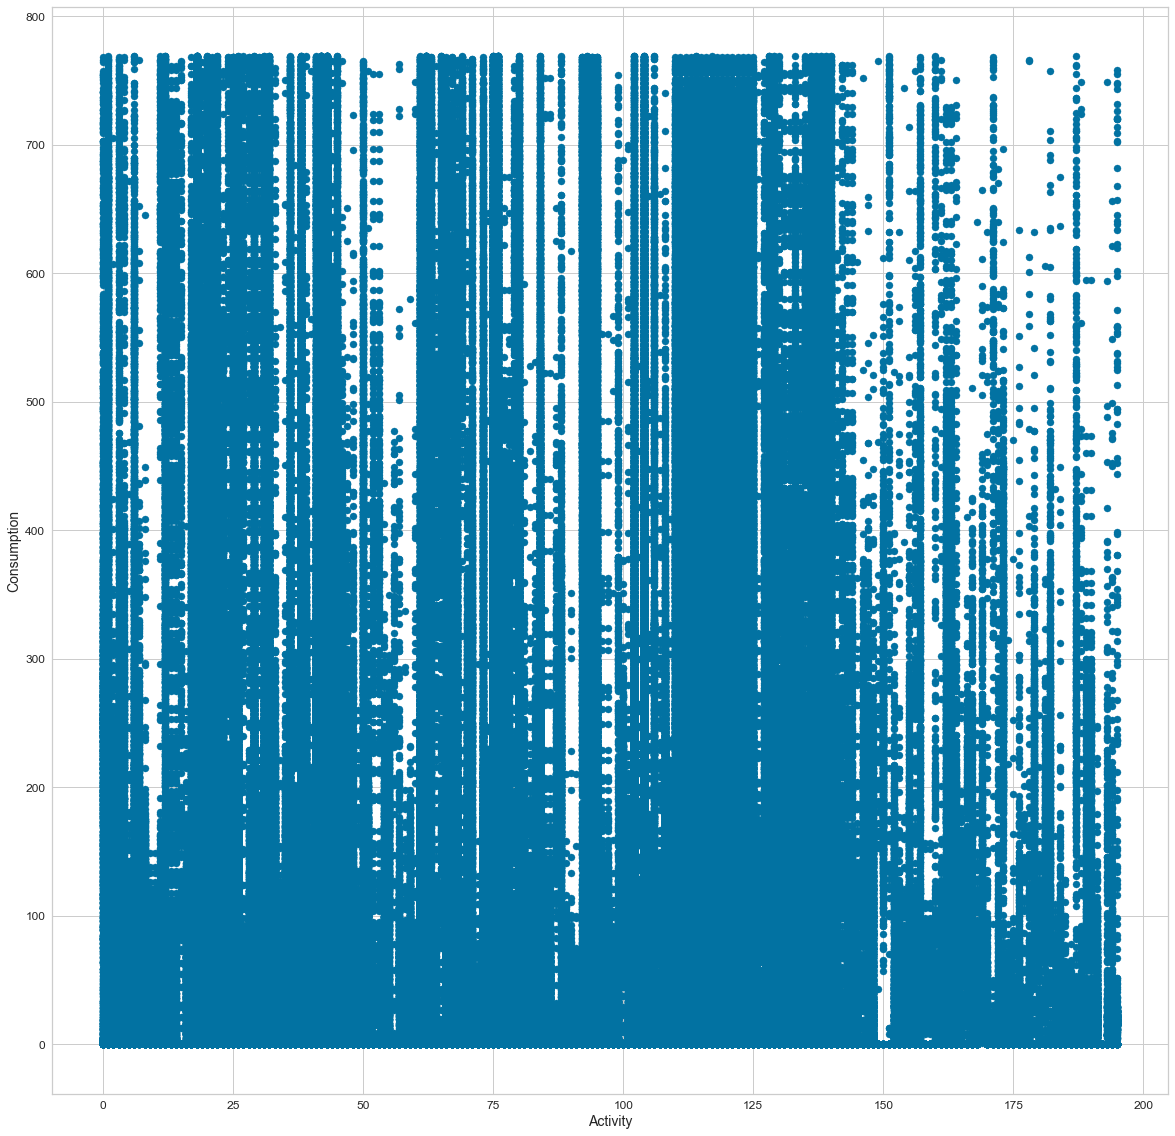

In [50]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(x=data_actividad['DESCP EPIGRAF'], y=data_actividad['CONSUMO'], s=50)
ax.set_xlabel(r'Activity', fontsize=14)
ax.set_ylabel(r'Consumption', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

KMeans()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

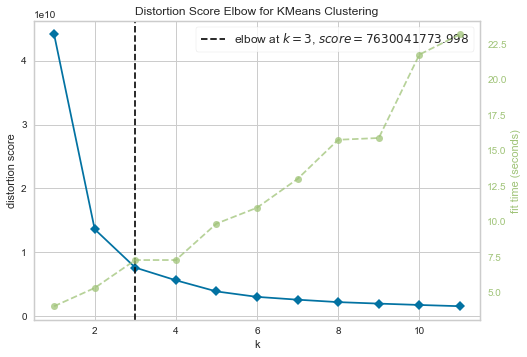

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
print(model)
visualizer = KElbowVisualizer(model, k=(1,12)).fit(data_actividad)
visualizer.show()

In [52]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(data_actividad)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [53]:
print(kmeans.labels_) # gives predicted class labels (cluster) for each data point
print(kmeans.inertia_) # gives within-cluster sum of squares
print(kmeans.n_iter_) # number of iterations that k-means algorithm runs to get a minimum within-cluster sum of squares
print(kmeans.cluster_centers_) # Location of the centroids on each cluster

[1 0 0 ... 0 1 1]
7630386070.867974
8
[[219.03269967  71.8764138 ]
 [ 23.28861438  73.84259873]
 [533.6699344   68.7303825 ]]


In [54]:
from collections import Counter
Counter(kmeans.labels_) # get each cluster size

Counter({1: 1137120, 0: 310960, 2: 135473})

Creating legend with loc="best" can be slow with large amounts of data.


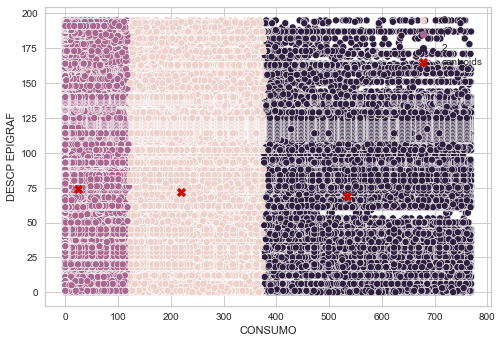

In [55]:
# Visualization of Kmeans clustering
sns.scatterplot(data=data_actividad, x="CONSUMO", y="DESCP EPIGRAF", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

Now, we will try to change the number of clusters to 5

In [56]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0).fit(data_actividad)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [57]:
print(kmeans.labels_) # gives predicted class labels (cluster) for each data point
print(kmeans.inertia_) # gives within-cluster sum of squares
print(kmeans.n_iter_) # number of iterations that k-means algorithm runs to get a minimum within-cluster sum of squares
print(kmeans.cluster_centers_) # Location of the centroids on each cluster

[1 0 3 ... 0 1 1]
3904157128.261213
7
[[158.76445481  72.82418915]
 [ 16.84758797  36.40628313]
 [596.22995066  68.0355059 ]
 [346.79835795  69.83564967]
 [ 17.17864197 119.00081383]]


In [58]:
Counter(kmeans.labels_) # get each cluster size

Counter({1: 577202, 0: 295015, 3: 144952, 2: 86267, 4: 480117})

Creating legend with loc="best" can be slow with large amounts of data.


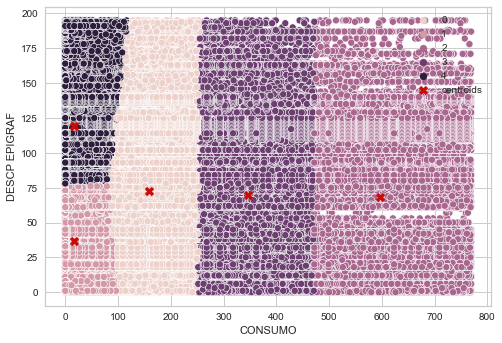

In [59]:
# Visualization of Kmeans clustering
sns.scatterplot(data=data_actividad, x="CONSUMO", y="DESCP EPIGRAF", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

In [60]:
# explorar clusters
from sklearn.metrics import pairwise_distances_argmin_min
#vemos el representante del grupo, la actividad cercano a su centroid (la posicion)
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, data_actividad)
closest

array([ 108320,  390534,  763004, 1161213,   90499], dtype=int64)

In [61]:
activities = [data_actividad_barcelona.iloc[elem,:] for elem in closest]
activities

[FECHA                            2019-05-07
 CONSUMO                                 159
 EPIGRAF                               I8497
 DESCP EPIGRAF    * de gestió administrativa
 ID_CLIENTE                              116
 LOCATION                          BARCELONA
 YEAR                                   2019
 MONTH                                     5
 MONTH_LONG                             Maig
 TEMPERATURE                            15.6
 Name: 129253, dtype: object,
 FECHA                                                2020-01-27
 CONSUMO                                                      17
 EPIGRAF                                                   I6441
 DESCP EPIGRAF    * al detall de pa, pastisseria confiteria i si
 ID_CLIENTE                                                  175
 LOCATION                                              BARCELONA
 YEAR                                                       2020
 MONTH                                                         1


In [62]:
pred_y = kmeans.predict(data_actividad)

In [63]:
pred_y

array([1, 0, 3, ..., 0, 1, 1])

## BLOCK 3: MULTIPLE LINEAR REGRESSION

Here we will use multiple linear regression to predict the water consumption depending on the censal section, month, number of man and woman, number of nacional people and foreigners in each census section

In [64]:
#OPEN DATA
data_sc = pd.read_csv("C:/Users/mirei/OneDrive/Escritorio/TFG/datasets/clean_datasets/block3/data_water_population_census_section.csv", sep=",")

In [65]:
data_sc

DIA  CONSUM  SECCIO_CENSAL  YEAR  MONTH  DAY  HOMES  DONES  \
0        2020-01-01     233           2166  2020      1    1   1016   1106   
1        2020-01-01     178           2166  2020      1    1   1016   1106   
2        2020-01-01     138           2166  2020      1    1   1016   1106   
3        2020-01-01     438           2166  2020      1    1   1016   1106   
4        2020-01-01       1           2166  2020      1    1   1016   1106   
...             ...     ...            ...   ...    ...  ...    ...    ...   
7999037  2021-12-09   30950           7098  2021     12    9   1007   1146   
7999038  2021-12-10   28200           7098  2021     12   10   1007   1146   
7999039  2021-12-11   26800           7098  2021     12   11   1007   1146   
7999040  2021-12-12   16680           7098  2021     12   12   1007   1146   
7999041  2021-12-13   38030           7098  2021     12   13   1007   1146   

         EDAT_0_A_14  EDAT_15_A_24  EDAT_25_A_64  EDAT_65_A_MES  NACIONALS  \
0                246           174          1300            402       1491   
1                246           174          1300            402       1491   
2                246           174          1300            402       1491   
3                246           174          1300            402       1491   
4                246           174          1300            402       1491   
...              ...           ...           ...            ...        ...   
7999037          302           236          1132            483       1986   
7999038          302           236          1132            483       1986   
7999039          302           236          1132            483       1986   
7999040          302           236          1132            483       1986   
7999041          302           236          1132            483       1986   

         COMUNITARIS  ESTRANGERS  Desc_Mes  Temperatura  \
0                223         408     Gener         10.0   
1                223         408     Gener         10.0   
2                223         408     Gener         10.0   
3                223         408     Gener         10.0   
4                223         408     Gener         10.0   
...              ...         ...       ...          ...   
7999037           61         106  Desembre         10.9   
7999038           61         106  Desembre         10.9   
7999039           61         106  Desembre         10.9   
7999040           61         106  Desembre         10.9   
7999041           61         106  Desembre         10.9   

         CONSUMPTION_PER_POPULATION  
0                          0.109802  
1                          0.083883  
2                          0.065033  
3                          0.206409  
4                          0.000471  
...                             ...  
7999037                   14.375290  
7999038                   13.098003  
7999039                   12.447747  
7999040                    7.747329  
7999041                   17.663725  

[7999042 rows x 18 columns]

In [66]:
data_seccio_censal = data_sc.drop(['DIA','YEAR', 'DAY', 'EDAT_0_A_14', 'EDAT_15_A_24', 'EDAT_25_A_64', 'EDAT_65_A_MES', 'Desc_Mes', 'Temperatura', 'CONSUMPTION_PER_POPULATION', 'COMUNITARIS'], axis=1)
data_seccio_censal

CONSUM  SECCIO_CENSAL  MONTH  HOMES  DONES  NACIONALS  ESTRANGERS
0           233           2166      1   1016   1106       1491         408
1           178           2166      1   1016   1106       1491         408
2           138           2166      1   1016   1106       1491         408
3           438           2166      1   1016   1106       1491         408
4             1           2166      1   1016   1106       1491         408
...         ...            ...    ...    ...    ...        ...         ...
7999037   30950           7098     12   1007   1146       1986         106
7999038   28200           7098     12   1007   1146       1986         106
7999039   26800           7098     12   1007   1146       1986         106
7999040   16680           7098     12   1007   1146       1986         106
7999041   38030           7098     12   1007   1146       1986         106

[7999042 rows x 7 columns]

In [67]:
feat = ['SECCIO_CENSAL', 'MONTH', 'HOMES', 'DONES', 'NACIONALS', 'ESTRANGERS']

In [68]:
y_b3 = data_seccio_censal['CONSUM'].to_numpy()
x_b3 = data_seccio_censal.iloc[:, 1:7]
x_b3 = x_b3.to_numpy()

In [69]:
x_b3

array([[2166,    1, 1016, 1106, 1491,  408],
       [2166,    1, 1016, 1106, 1491,  408],
       [2166,    1, 1016, 1106, 1491,  408],
       ...,
       [7098,   12, 1007, 1146, 1986,  106],
       [7098,   12, 1007, 1146, 1986,  106],
       [7098,   12, 1007, 1146, 1986,  106]], dtype=int64)

In [70]:
y_b3

array([  233,   178,   138, ..., 26800, 16680, 38030], dtype=int64)

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x_b3,y_b3, train_size=0.8)

In [72]:
model_b3 = LinearRegression().fit(x_train, y_train)

r_sq = model_b3.score(x_train, y_train)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model_b3.intercept_}")

print(f"coefficients: {model_b3.coef_}")

coefficient of determination: 1.489291024381334e-05
intercept: 398.097705696327
coefficients: [   1.60270735 -119.79942757   14.55984024    1.61152845   -9.05744677
  -12.4154862 ]


In [73]:
y_pred = model_b3.predict(x_test)
print(f"predicted response:\n{y_pred}")

predicted response:
[1533.37734489 2976.9929975  2640.66526958 ...  724.62033905 1149.61173537
 1580.73641441]


In [74]:
from sklearn.metrics import explained_variance_score, max_error, r2_score, mean_squared_error, d2_absolute_error_score, mean_absolute_percentage_error
#https://scikit-learn.org/stable/modules/model_evaluation.html

#explained variance score
print('Explained variance score: ', explained_variance_score(y_test, y_pred))
#max error
print('Max error: ', max_error(y_test, y_pred))
#r2
print('R2 score: ', r2_score(y_test, y_pred))
#mean squared error
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
#d2
print('D2 absolute error score:', d2_absolute_error_score(y_test, y_pred))
#mean absolute percentage error
print('Mean absolute percentage error: ', mean_absolute_percentage_error(y_test, y_pred))

Explained variance score:  7.884966882865108e-06
Max error:  451417853.1937948
R2 score:  7.65569872596128e-06
Mean squared error:  159897546983.60092
D2 absolute error score: -0.7551816264860653
Mean absolute percentage error:  320924699110886.44


### INTERPRETATION: SHAP VALUES

In [75]:
#Create the explainer
explainer = shap.LinearExplainer(model_b3, x_train)

#Calculate the shap_values for x_test
shap_values = explainer(x_test)

Linear explainer: 1599810it [00:45, 35046.51it/s]                             


In [76]:
shap_values

.values =
array([[  930.6440762 ,  -186.88710701,  3735.03581791,   458.04473153,
        -2758.26426609, -2625.00624745],
       [  879.35744104,   -67.08767944, -4098.1582336 ,  -446.02272929,
         2884.52507412,  1844.56878486],
       [  896.98722188,   412.11003085,   560.99064462,    68.05484647,
        -2078.95575804,   801.66794399],
       ...,
       [ -588.72249042,   531.90945842,  2220.81243248,   495.10988589,
        -3673.06639026,  -241.23289688],
       [ -652.83078437,  -306.68653459,   750.2685678 ,   200.20017942,
        -1300.01533547,   478.86530277],
       [ -555.06563609,   651.708886  , -1797.70347498,   -78.59424254,
         -675.05150807,  2055.63205028]])

.base_values =
array([1979.81033981, 1979.81033981, 1979.81033981, ..., 1979.81033981,
       1979.81033981, 1979.81033981])

.data =
array([[3053,    8, 1051, 1140, 1479,  527],
       [3021,    7,  513,  579,  856,  167],
       [3032,    3,  833,  898, 1404,  251],
       ...,
       [2105,    

Now we will focus on the first element

In [77]:
print("Shap values for first element: \n", shap_values[0])

Shap values for first element: 
 .values =
array([  930.6440762 ,  -186.88710701,  3735.03581791,   458.04473153,
       -2758.26426609, -2625.00624745])

.base_values =
1979.8103398092148

.data =
array([3053,    8, 1051, 1140, 1479,  527], dtype=int64)


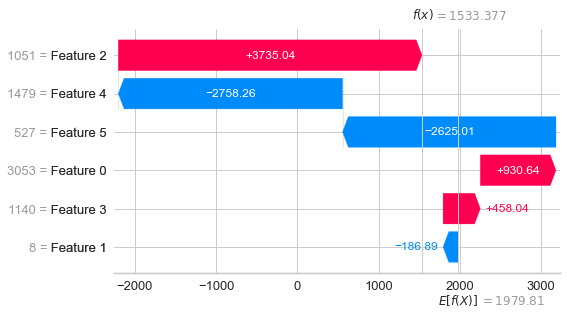

In [78]:
#waterfall
shap.plots.waterfall(shap_values[0])

In [79]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0], link = "logit", features = feat)

In [80]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0], features = feat)

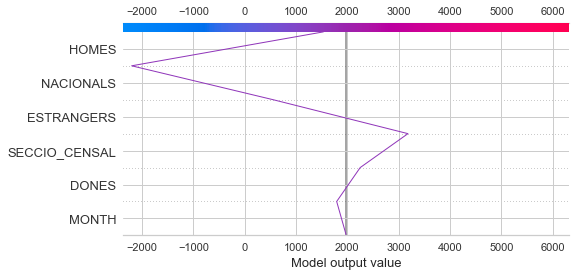

In [81]:
#decision_plot
shap.decision_plot(explainer.expected_value, shap_values.values[0], features = feat)

#### Global explanation

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


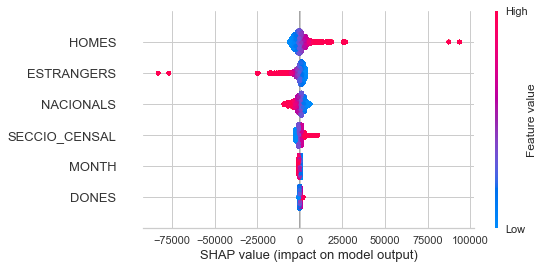

In [82]:
shap.summary_plot(shap_values, x_test, feature_names = feat)

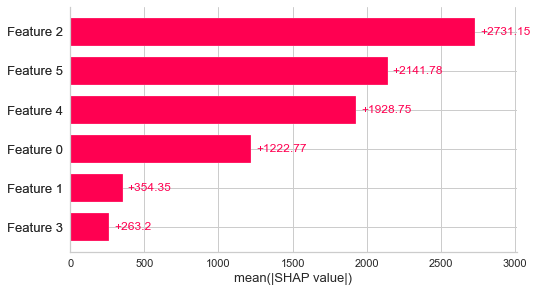

In [83]:
shap.plots.bar(shap_values)

## BLOCK 4: MULTIPLE LINEAR REGRESSION

We will create a model to predict the consumption depending on the year, postal code, month, temperature, sector and electricity consumption

In [84]:
# OPEN DATA
data_postal_code_industrial = pd.read_csv("C:/Users/mirei/OneDrive/Escritorio/TFG/datasets/clean_datasets/block4/data_industrial_postal_code.csv", sep=",")
data_postal_code_residencial = pd.read_csv("C:/Users/mirei/OneDrive/Escritorio/TFG/datasets/clean_datasets/block4/data_residencial_postal_code.csv", sep=",")

In [85]:
data_postal_code_residencial

DIA  COD_POST_ADRE  CONSUM  YEAR  MONTH  DAY Desc_Mes  \
0      2021-04-14           8036     597  2021      4   14    Abril   
1      2021-04-03           8004     408  2021      4    3    Abril   
2      2021-04-01           8027    1831  2021      4    1    Abril   
3      2021-04-05           8031    1046  2021      4    5    Abril   
4      2021-04-15           8014     440  2021      4   15    Abril   
...           ...            ...     ...   ...    ...  ...      ...   
45201  2019-03-13           8005    4257  2019      3   13     Març   
45202  2019-03-13           8018    1614  2019      3   13     Març   
45203  2019-03-24           8020     298  2019      3   24     Març   
45204  2019-03-13           8008     811  2019      3   13     Març   
45205  2019-03-24           8010     883  2019      3   24     Març   

       Temperatura Sector_Economic   Valor  
0             12.9     Residencial   93768  
1             12.9     Residencial  113620  
2             12.9     Residencial  173196  
3             12.9     Residencial  112638  
4             12.9     Residencial  198209  
...            ...             ...     ...  
45201         13.5     Residencial  213290  
45202         13.5     Residencial  199105  
45203         13.5     Residencial  138470  
45204         13.5     Residencial   52578  
45205         13.5     Residencial   41414  

[45206 rows x 10 columns]

In [86]:
data_postal_code_industrial

DIA  COD_POST_ADRE  CONSUM  YEAR  MONTH  DAY Desc_Mes  \
0      2021-04-14           8036     597  2021      4   14    Abril   
1      2021-04-03           8004     408  2021      4    3    Abril   
2      2021-04-01           8027    1831  2021      4    1    Abril   
3      2021-04-05           8031    1046  2021      4    5    Abril   
4      2021-04-15           8014     440  2021      4   15    Abril   
...           ...            ...     ...   ...    ...  ...      ...   
45201  2019-03-13           8005    4257  2019      3   13     Març   
45202  2019-03-13           8018    1614  2019      3   13     Març   
45203  2019-03-24           8020     298  2019      3   24     Març   
45204  2019-03-13           8008     811  2019      3   13     Març   
45205  2019-03-24           8010     883  2019      3   24     Març   

       Temperatura Sector_Economic   Valor  
0             12.9       Indústria    9487  
1             12.9       Indústria  181905  
2             12.9       Indústria    4800  
3             12.9       Indústria    1723  
4             12.9       Indústria   13766  
...            ...             ...     ...  
45201         13.5       Indústria   37666  
45202         13.5       Indústria   66164  
45203         13.5       Indústria   46120  
45204         13.5       Indústria    8603  
45205         13.5       Indústria    2321  

[45206 rows x 10 columns]

In [87]:
# residencial 1, industrial 0
data_postal_code_industrial['Sector'] = 0
data_postal_code_residencial['Sector'] = 1
data_postal_code = pd.concat([data_postal_code_industrial, data_postal_code_residencial], axis=0)
data_postal_code

DIA  COD_POST_ADRE  CONSUM  YEAR  MONTH  DAY Desc_Mes  \
0      2021-04-14           8036     597  2021      4   14    Abril   
1      2021-04-03           8004     408  2021      4    3    Abril   
2      2021-04-01           8027    1831  2021      4    1    Abril   
3      2021-04-05           8031    1046  2021      4    5    Abril   
4      2021-04-15           8014     440  2021      4   15    Abril   
...           ...            ...     ...   ...    ...  ...      ...   
45201  2019-03-13           8005    4257  2019      3   13     Març   
45202  2019-03-13           8018    1614  2019      3   13     Març   
45203  2019-03-24           8020     298  2019      3   24     Març   
45204  2019-03-13           8008     811  2019      3   13     Març   
45205  2019-03-24           8010     883  2019      3   24     Març   

       Temperatura Sector_Economic   Valor  Sector  
0             12.9       Indústria    9487       0  
1             12.9       Indústria  181905       0  
2             12.9       Indústria    4800       0  
3             12.9       Indústria    1723       0  
4             12.9       Indústria   13766       0  
...            ...             ...     ...     ...  
45201         13.5     Residencial  213290       1  
45202         13.5     Residencial  199105       1  
45203         13.5     Residencial  138470       1  
45204         13.5     Residencial   52578       1  
45205         13.5     Residencial   41414       1  

[90412 rows x 11 columns]

In [88]:
data_postal_code_clean = data_postal_code.drop(['DIA', 'DAY', 'Sector_Economic', 'Desc_Mes'], axis=1)
data_postal_code_clean

COD_POST_ADRE  CONSUM  YEAR  MONTH  Temperatura   Valor  Sector
0               8036     597  2021      4         12.9    9487       0
1               8004     408  2021      4         12.9  181905       0
2               8027    1831  2021      4         12.9    4800       0
3               8031    1046  2021      4         12.9    1723       0
4               8014     440  2021      4         12.9   13766       0
...              ...     ...   ...    ...          ...     ...     ...
45201           8005    4257  2019      3         13.5  213290       1
45202           8018    1614  2019      3         13.5  199105       1
45203           8020     298  2019      3         13.5  138470       1
45204           8008     811  2019      3         13.5   52578       1
45205           8010     883  2019      3         13.5   41414       1

[90412 rows x 7 columns]

In [89]:
features = ['YEAR', 'MONTH', 'Temperatura', 'Valor', 'Sector', 'COD_POST_ADRE']

In [90]:
y = data_postal_code_clean['CONSUM'].to_numpy()
x = data_postal_code_clean.iloc[:, 2:7]
x['POSTAL_CODE'] = data_postal_code_clean['COD_POST_ADRE']
x = x.to_numpy()

In [91]:
x

array([[2.02100e+03, 4.00000e+00, 1.29000e+01, 9.48700e+03, 0.00000e+00,
        8.03600e+03],
       [2.02100e+03, 4.00000e+00, 1.29000e+01, 1.81905e+05, 0.00000e+00,
        8.00400e+03],
       [2.02100e+03, 4.00000e+00, 1.29000e+01, 4.80000e+03, 0.00000e+00,
        8.02700e+03],
       ...,
       [2.01900e+03, 3.00000e+00, 1.35000e+01, 1.38470e+05, 1.00000e+00,
        8.02000e+03],
       [2.01900e+03, 3.00000e+00, 1.35000e+01, 5.25780e+04, 1.00000e+00,
        8.00800e+03],
       [2.01900e+03, 3.00000e+00, 1.35000e+01, 4.14140e+04, 1.00000e+00,
        8.01000e+03]])

In [92]:
y

array([ 597,  408, 1831, ...,  298,  811,  883], dtype=int64)

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8)

In [94]:
model_b4 = LinearRegression().fit(x_train, y_train)

r_sq = model_b4.score(x, y)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model_b4.intercept_}")

print(f"coefficients: {model_b4.coef_}")

coefficient of determination: 0.002845100088191499
intercept: 2597368.4044993403
coefficients: [-2.14733853e+03 -2.76620715e+02  1.62860747e+02 -4.51265099e-04
  2.44207906e+02  2.17382676e+02]


In [95]:
y_pred = model_b4.predict(x_test)
print(f"predicted response:\n{y_pred}")

predicted response:
[6632.01981659 7285.63153744 5563.39575382 ... 3336.8608766  7281.08129598
 5601.46280851]


In [96]:
from sklearn.metrics import explained_variance_score, max_error, r2_score, mean_squared_error, d2_absolute_error_score, mean_absolute_percentage_error
#https://scikit-learn.org/stable/modules/model_evaluation.html

#explained variance score
print('Explained variance score: ', explained_variance_score(y_test, y_pred))
#max error
print('Max error: ', max_error(y_test, y_pred))
#r2
print('R2 score: ', r2_score(y_test, y_pred))
#mean squared error
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
#d2
print('D2 absolute error score:', d2_absolute_error_score(y_test, y_pred))
#mean absolute percentage error
print('Mean absolute percentage error: ', mean_absolute_percentage_error(y_test, y_pred))

Explained variance score:  0.004180767710908806
Max error:  6171851.518873692
R2 score:  0.004171913288030349
Mean squared error:  2274259547.241805
D2 absolute error score: -0.32947931358950555
Mean absolute percentage error:  4.9392168251719895


#### INTERPRETATION: SHAP VALUES

In [97]:
#Create the explainer
explainer = shap.LinearExplainer(model_b4, x_train)

#Calculate the shap_values for x_test
shap_values = explainer(x_test)

In [98]:
shap_values

.values =
array([[ 2.21175869e+03,  9.65406296e+02, -6.34505469e+02,
         4.62312069e-01, -1.09893558e+02, -5.86933226e+01],
       [ 6.44201560e+01, -1.24755943e+03, -4.39072573e+02,
         3.65265163e+01, -1.09893558e+02,  4.72372555e+03],
       [ 6.44201560e+01,  9.65406296e+02, -8.95082663e+02,
         3.54579205e+01, -1.09893558e+02,  1.24560273e+03],
       ...,
       [ 6.44201560e+01, -1.41076565e+02,  1.23839312e+03,
         1.58450368e+01,  1.34314348e+02, -2.23252008e+03],
       [ 2.21175869e+03, -1.52418014e+03, -1.00908519e+03,
         3.55671267e+01, -1.09893558e+02,  3.41942950e+03],
       [-2.08291838e+03,  1.24202701e+03, -9.43940887e+02,
         3.66569319e+01, -1.09893558e+02,  3.20204682e+03]])

.base_values =
array([4257.48486755, 4257.48486755, 4257.48486755, ..., 4257.48486755,
       4257.48486755, 4257.48486755])

.data =
array([[2.0190e+03, 3.0000e+00, 1.3500e+01, 8.3556e+04, 0.0000e+00,
        8.0200e+03],
       [2.0200e+03, 1.1000e+01, 1.4700e

Now we will focus on the first element

In [99]:
print("Shap values for first element: \n", shap_values[0])

Shap values for first element: 
 .values =
array([ 2.21175869e+03,  9.65406296e+02, -6.34505469e+02,  4.62312069e-01,
       -1.09893558e+02, -5.86933226e+01])

.base_values =
4257.484867553692

.data =
array([2.0190e+03, 3.0000e+00, 1.3500e+01, 8.3556e+04, 0.0000e+00,
       8.0200e+03])


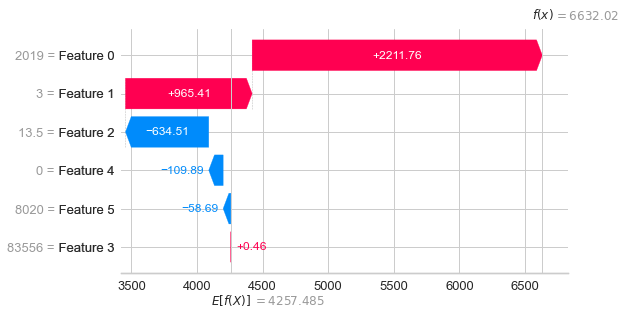

In [100]:
#waterfall
shap.plots.waterfall(shap_values[0])

In [101]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0],features= features, link = "logit")

In [102]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0], features= features)

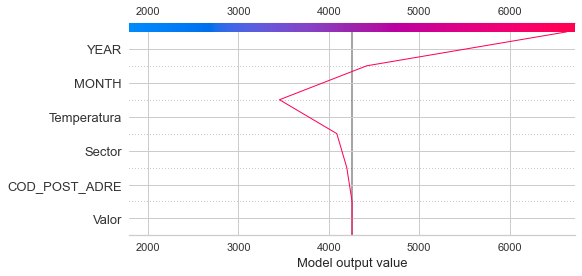

In [103]:
#decision_plot
shap.decision_plot(explainer.expected_value, shap_values.values[0], features= features)

#### Global explanation

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


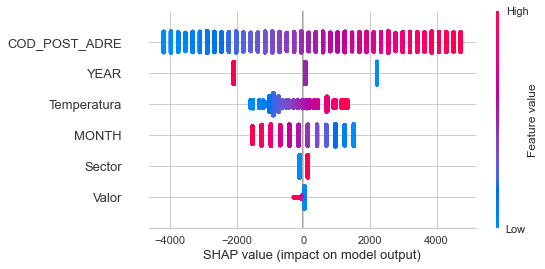

In [104]:
shap.summary_plot(shap_values, x_test, feature_names = features)

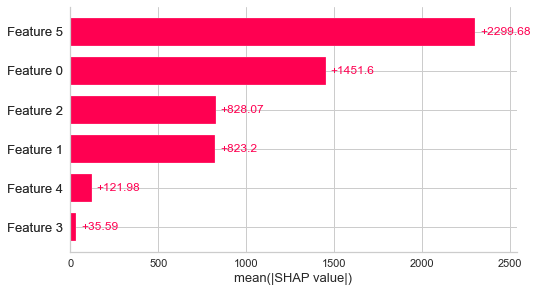

In [105]:
shap.plots.bar(shap_values)

## BLOCK 5: MULTIPLE LINEAR REGRESSION

In this block we will predict the water consumption depeding on the district, month, rent, number of population per district zone

In [106]:
#OPEN DATA
data_rent = pd.read_csv("C:/Users/mirei/OneDrive/Escritorio/TFG/datasets/clean_datasets/block5/data_rent_disctrict.csv", sep=",")

In [107]:
data_rent

DIA    DISTRICTE  CONSUM  YEAR  MONTH  DAY  Any_x  \
0     2019-01-01  SANT ANDREU    1890  2019      1    1   2019   
1     2019-01-02  SANT ANDREU    1835  2019      1    2   2019   
2     2019-01-03  SANT ANDREU    1812  2019      1    3   2019   
3     2019-01-04  SANT ANDREU    1813  2019      1    4   2019   
4     2019-01-05  SANT ANDREU    1704  2019      1    5   2019   
...          ...          ...     ...   ...    ...  ...    ...   
5463  2020-12-26   SANT MARTI     701  2020     12   26   2020   
5464  2020-12-27   SANT MARTI     673  2020     12   27   2020   
5465  2020-12-28   SANT MARTI     732  2020     12   28   2020   
5466  2020-12-30   SANT MARTI     719  2020     12   30   2020   
5467  2020-12-31   SANT MARTI     832  2020     12   31   2020   

     Nom_Districte_x  Import_Euros Nom_Districte_y  Any_y  Nombre  \
0        SANT ANDREU      36717.19     SANT ANDREU   2019  150264   
1        SANT ANDREU      36717.19     SANT ANDREU   2019  150264   
2        SANT ANDREU      36717.19     SANT ANDREU   2019  150264   
3        SANT ANDREU      36717.19     SANT ANDREU   2019  150264   
4        SANT ANDREU      36717.19     SANT ANDREU   2019  150264   
...              ...           ...             ...    ...     ...   
5463      SANT MARTI      37713.01      SANT MARTI   2020  241691   
5464      SANT MARTI      37713.01      SANT MARTI   2020  241691   
5465      SANT MARTI      37713.01      SANT MARTI   2020  241691   
5466      SANT MARTI      37713.01      SANT MARTI   2020  241691   
5467      SANT MARTI      37713.01      SANT MARTI   2020  241691   

      RENT_PER_POPULATION  
0                0.244351  
1                0.244351  
2                0.244351  
3                0.244351  
4                0.244351  
...                   ...  
5463             0.156038  
5464             0.156038  
5465             0.156038  
5466             0.156038  
5467             0.156038  

[5468 rows x 13 columns]

In [108]:
data_rent_clean = data_rent.drop(['YEAR', 'DAY', 'DIA','Nom_Districte_x', 'Any_x', 'Nom_Districte_y', 'Any_y','RENT_PER_POPULATION'], axis=1)
data_rent_clean

DISTRICTE  CONSUM  MONTH  Import_Euros  Nombre
0     SANT ANDREU    1890      1      36717.19  150264
1     SANT ANDREU    1835      1      36717.19  150264
2     SANT ANDREU    1812      1      36717.19  150264
3     SANT ANDREU    1813      1      36717.19  150264
4     SANT ANDREU    1704      1      36717.19  150264
...           ...     ...    ...           ...     ...
5463   SANT MARTI     701     12      37713.01  241691
5464   SANT MARTI     673     12      37713.01  241691
5465   SANT MARTI     732     12      37713.01  241691
5466   SANT MARTI     719     12      37713.01  241691
5467   SANT MARTI     832     12      37713.01  241691

[5468 rows x 5 columns]

In [109]:
# mapping districts to ints
mapping_to_int = {}
contador = 0
for district in data_rent_clean['DISTRICTE'].unique():
    mapping_to_int[district] = contador
    contador = contador+1
mapping_to_int

{'SANT ANDREU': 0,
 'CIUTAT VELLA': 1,
 'GRACIA': 2,
 'SANT MARTI': 3,
 'EIXAMPLE': 4,
 'LES CORTS': 5,
 'SANTS-MONTJUIC': 6,
 'NOU BARRIS': 7}

In [110]:
data_rent_clean['DISTRICTE'] = [int(mapping_to_int[data]) for data in data_rent_clean['DISTRICTE']]
data_rent_clean

DISTRICTE  CONSUM  MONTH  Import_Euros  Nombre
0             0    1890      1      36717.19  150264
1             0    1835      1      36717.19  150264
2             0    1812      1      36717.19  150264
3             0    1813      1      36717.19  150264
4             0    1704      1      36717.19  150264
...         ...     ...    ...           ...     ...
5463          3     701     12      37713.01  241691
5464          3     673     12      37713.01  241691
5465          3     732     12      37713.01  241691
5466          3     719     12      37713.01  241691
5467          3     832     12      37713.01  241691

[5468 rows x 5 columns]

In [111]:
f = ['MONTH', 'Import_Euros', 'Nombre', 'DISTRICTE']

In [112]:
y = data_rent_clean['CONSUM'].to_numpy()
x = data_rent_clean.iloc[:, 2:5]
x['DISTRICTE'] = data_rent_clean['DISTRICTE']
x = x.to_numpy()

In [113]:
x

array([[1.000000e+00, 3.671719e+04, 1.502640e+05, 0.000000e+00],
       [1.000000e+00, 3.671719e+04, 1.502640e+05, 0.000000e+00],
       [1.000000e+00, 3.671719e+04, 1.502640e+05, 0.000000e+00],
       ...,
       [1.200000e+01, 3.771301e+04, 2.416910e+05, 3.000000e+00],
       [1.200000e+01, 3.771301e+04, 2.416910e+05, 3.000000e+00],
       [1.200000e+01, 3.771301e+04, 2.416910e+05, 3.000000e+00]])

In [114]:
y

array([1890, 1835, 1812, ...,  732,  719,  832], dtype=int64)

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8)

In [116]:
model_b5 = LinearRegression().fit(x_train, y_train)

r_sq = model_b5.score(x, y)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model_b5.intercept_}")

print(f"coefficients: {model_b5.coef_}")

coefficient of determination: 0.00485405983607079
intercept: 1916.9151915623493
coefficients: [-6.37722671e+01  8.73512941e-04 -1.50612764e-04  6.85716626e+00]


In [117]:
y_pred = model_b5.predict(x_test)
print(f"predicted response:\n{y_pred}")

predicted response:
[1884.87348053 1360.41478709 1502.02098188 ... 1241.378078   1870.59292403
 1348.58441976]


In [118]:
from sklearn.metrics import explained_variance_score, max_error, r2_score, mean_squared_error, d2_absolute_error_score, mean_absolute_percentage_error
#https://scikit-learn.org/stable/modules/model_evaluation.html

#explained variance score
print('Explained variance score: ', explained_variance_score(y_test, y_pred))
#max error
print('Max error: ', max_error(y_test, y_pred))
#r2
print('R2 score: ', r2_score(y_test, y_pred))
#mean squared error
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
#d2
print('D2 absolute error score:', d2_absolute_error_score(y_test, y_pred))
#mean absolute percentage error
print('Mean absolute percentage error: ', mean_absolute_percentage_error(y_test, y_pred))

Explained variance score:  0.004987644999757901
Max error:  80763.5167910726
R2 score:  0.004547859098612106
Mean squared error:  6430398.550933137
D2 absolute error score: 0.027528568462394265
Mean absolute percentage error:  0.3697557886002338


### INTERPRETATION: SHAP VALUES

In [119]:
#Create the explainer
explainer = shap.LinearExplainer(model_b5, x_train)

#Calculate the shap_values for x_test
shap_values = explainer(x_test)

In [120]:
shap_values

.values =
array([[ 3.30978066e+02,  3.33230590e+00,  5.66771041e+00,
        -1.17257543e+01],
       [-1.79200071e+02, -1.50136871e-01, -1.19875696e+01,
        -4.86858804e+00],
       [-5.16555364e+01,  3.23359894e+00,  5.54752143e+00,
        -1.17257543e+01],
       ...,
       [-3.06744605e+02,  5.87115380e+00, -1.63582014e+01,
         1.98857822e+00],
       [ 3.30978066e+02, -1.50136871e-01, -1.19875696e+01,
        -4.86858804e+00],
       [-2.42972338e+02,  1.43581793e+01,  1.17316815e+01,
         8.84574448e+00]])

.base_values =
array([1556.62115218, 1556.62115218, 1556.62115218, ..., 1556.62115218,
       1556.62115218, 1556.62115218])

.data =
array([[1.000000e+00, 4.180757e+04, 1.228530e+05, 2.000000e+00],
       [9.000000e+00, 3.782086e+04, 2.400760e+05, 3.000000e+00],
       [7.000000e+00, 4.169457e+04, 1.236510e+05, 2.000000e+00],
       ...,
       [1.100000e+01, 4.471405e+04, 2.690950e+05, 4.000000e+00],
       [1.000000e+00, 3.782086e+04, 2.400760e+05, 3.000000e+

Now we will focus on the first element

In [121]:
print("Shap values for first element: \n", shap_values[0])

Shap values for first element: 
 .values =
array([330.97806634,   3.3323059 ,   5.66771041, -11.7257543 ])

.base_values =
1556.621152181906

.data =
array([1.000000e+00, 4.180757e+04, 1.228530e+05, 2.000000e+00])


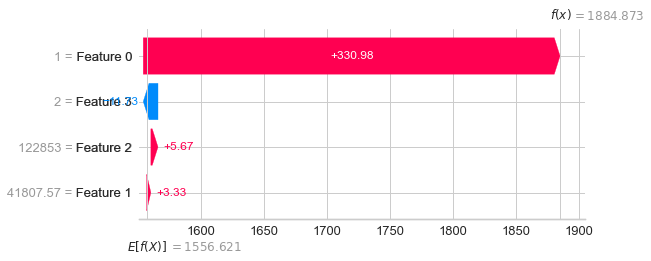

In [122]:
#waterfall
shap.plots.waterfall(shap_values[0])

In [123]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0], link = "logit", features = f)

In [124]:
shap.initjs()
#force_plot with logit parameter
shap.force_plot(explainer.expected_value, shap_values.values[0], features = f)

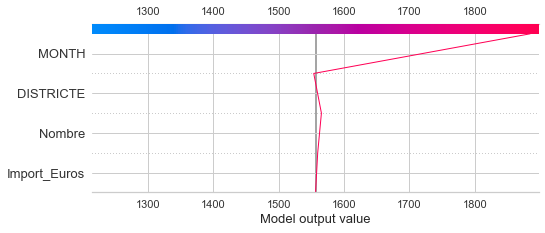

In [125]:
#decision_plot
shap.decision_plot(explainer.expected_value, shap_values.values[0], features = f)

#### Global interpretation

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


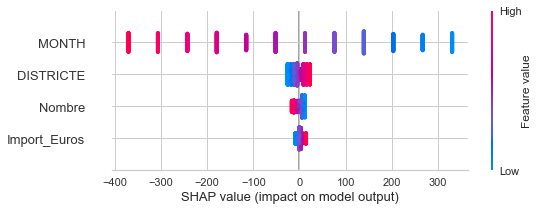

In [126]:
shap.summary_plot(shap_values, x_test, feature_names = f)

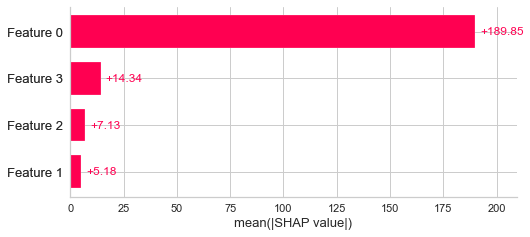

In [127]:
shap.plots.bar(shap_values)